In [1]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import pandas as pd
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException
from datetime import datetime
import calendar
import json
import csv
import numpy as np
from selenium import webdriver
import time
import math
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

## Data Preparation

We will only keep the columns that we need.

In [2]:
gas_stations = pd.read_csv('Gas_Stations_04_06.csv')
gas_stations['Franchise (or private)'] = gas_stations['Franchise (or private)'].replace('Mobil Gáz', 'Magán')

In [3]:
gas_stations = gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway','95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Cng', 'Prémium Gázolaj', 'Prémium Benzin E10','98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő','Ccs - Elektromos Töltő', 'Number of competition 1km','Number of competition 5km',
                            'Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']]

gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway']] = gas_stations[['City', 'Post Code','Franchise (or private)', 'Highway']].astype('category')

radius = ['Number of competition 1km','Number of competition 5km','Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']
gas_stations[radius] = gas_stations[radius].astype('int')

## City Attribute:

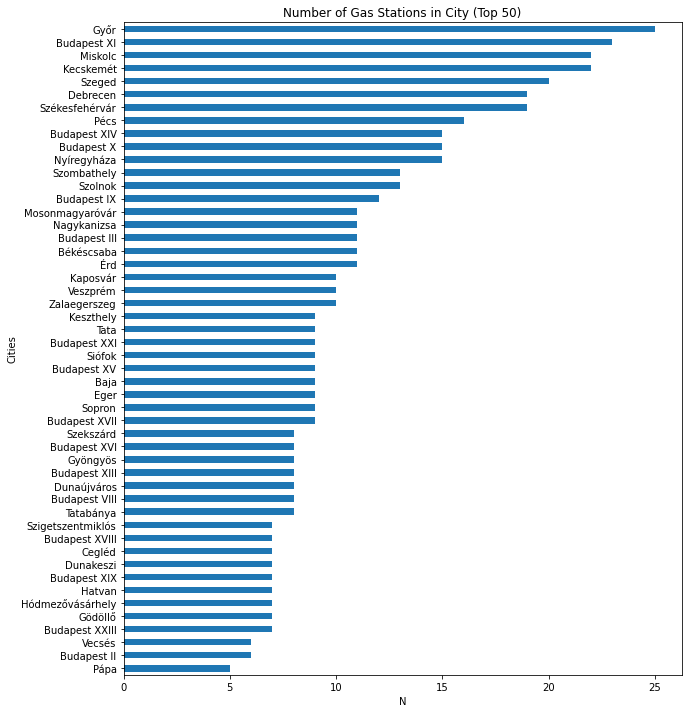

In [4]:
counts = gas_stations['City'].value_counts()[:50].sort_values(ascending = True)

plt.figure(figsize=(10, 12))
counts.plot(kind='barh')

plt.title('Number of Gas Stations in City (Top 50)')
plt.xlabel('N')
plt.ylabel('Cities')
plt.show()

We would like to check the relationship between the **City and Franchise** attribute. For independence we use Chi Squared test.

In [5]:
# Create a contingency table
cont_table = pd.crosstab(gas_stations['City'], gas_stations['Franchise (or private)'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for City and Franchise: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for City and Franchise: 3657.8629274539476
P-value: 0.0012011102447612128


In this case, the chi-square statistic of 3657.86 is relatively large, and the small p-value of 0.0012 indicates strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant association between City and Franchise (or private) status of gas stations

**City (and highway) and Gas Prices**: We will group by cities (and highway) and calculate the average prices. We should check where the best and worst prices are.

In [6]:
from IPython.display import display, HTML

gas_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg',
             '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
             '98-As Benzin E5']

# create HTML and CSS for grid layout
html = "<style>.container { display: grid; grid-template-columns: repeat(5, 1fr); grid-gap: 20px; } </style>"
html += "<div class='container'>"

# loop through gas types and display top and worst 5 prices in a dataframe
for gas in gas_types:
    top_5 = gas_stations.groupby(['City', 'Highway'])[gas].mean().sort_values()[:5].to_frame()
    worst_5 = gas_stations.groupby(['City', 'Highway'])[gas].mean().sort_values(ascending = False)[:5].to_frame()
    
    # create HTML for each dataframe
    top_html = f"<h3>Top 5 Prices for {gas}</h3>{top_5.to_html()}"
    worst_html = f"<h3>Worst 5 Prices for {gas}</h3>{worst_5.to_html()}"
    
    # add HTML for each dataframe to the grid
    if gas == gas_types[-1]:
        html += f"<div>{top_html}</div><div>{worst_html}</div>"
    else:
        html += f"<div>{top_html}</div><div>{worst_html}</div>"

html += "</div>"

# display the grid
display(HTML(html))

,,95-ös Benzin E10
City,Highway,
Zsana,0,580.0
Sóskút,0,589.0
Hejőbába,0,590.0
Bekecs,0,590.0
Múcsony,0,590.0
,,95-ös Benzin E10
City,Highway,
Akasztó,0,651.0
Budapest XI,1,643.9


## Franchise variable
We already checked the relationship between the City and Franchise variable.

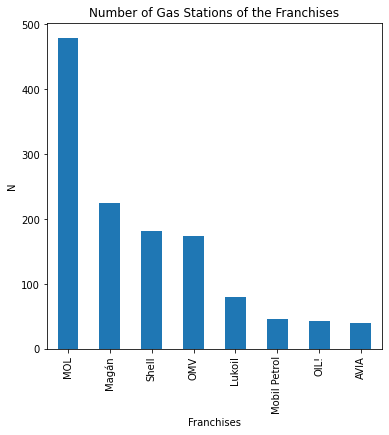

In [7]:
counts = gas_stations['Franchise (or private)'].value_counts()
plt.figure(figsize=(6, 6))
counts.plot(kind='bar')

plt.title('Number of Gas Stations of the Franchises')
plt.xlabel('Franchises')
plt.ylabel('N')
plt.show()

Next we should check the relationship between the Franchise and Highway attribute. We will use the same chi squared test.

In [8]:
cont_table = pd.crosstab(gas_stations['Franchise (or private)'], gas_stations['Highway'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for Franchise and Highway: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for Franchise and Highway: 42.84128415553539
P-value: 3.579460471015146e-07


This means that there is a significant association between the franchise and highway attribute.

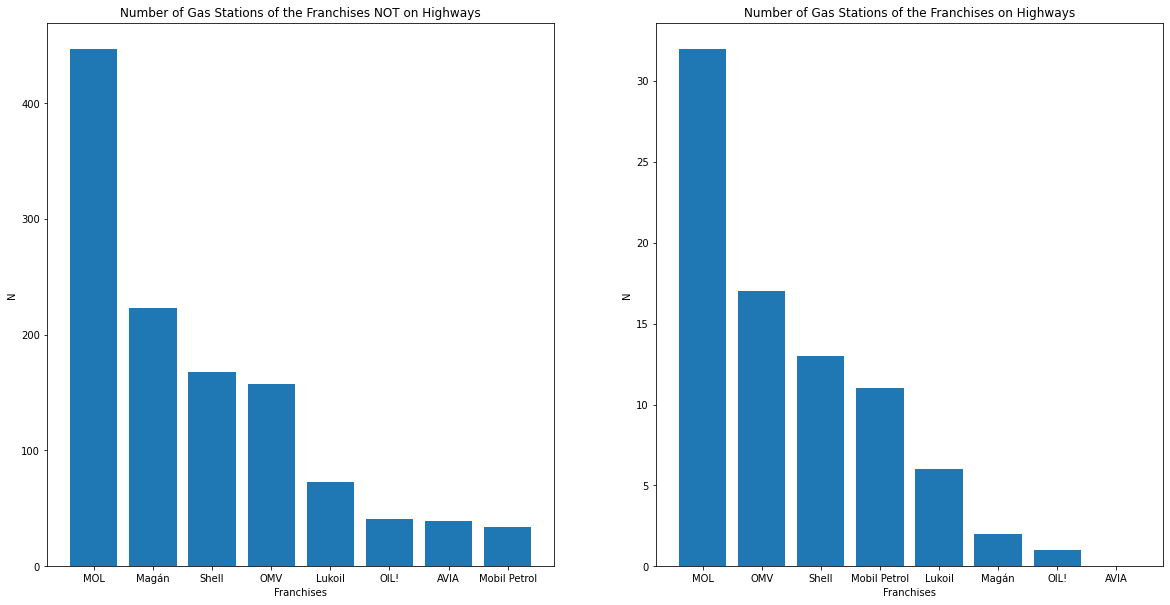

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot the first graph on the left subplot
not_on_highway = gas_stations.loc[gas_stations['Highway'] == 0]
counts_not = not_on_highway['Franchise (or private)'].value_counts()
axs[0].bar(counts_not.index, counts_not.values)
axs[0].set_title('Number of Gas Stations of the Franchises NOT on Highways')
axs[0].set_xlabel('Franchises')
axs[0].set_ylabel('N')

# Plot the second graph on the right subplot
on_highway = gas_stations.loc[gas_stations['Highway'] == 1]
counts = on_highway['Franchise (or private)'].value_counts()
axs[1].bar(counts.index, counts.values)
axs[1].set_title('Number of Gas Stations of the Franchises on Highways')
axs[1].set_xlabel('Franchises')
axs[1].set_ylabel('N')

# Show the plot
plt.show()

The average Price based on Franchise:

In [10]:
gas_stations.groupby(['Franchise (or private)'])[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].mean()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
Franchise (or private),,,,,,,,
AVIA,603.518750,597.605882,369.250000,638.866667,633.633333,NaN,NaN,578.500000
Lukoil,611.518987,591.544304,361.333333,642.392857,635.276596,NaN,NaN,NaN
MOL,611.139957,592.233118,354.735000,648.421077,647.353211,640.000000,NaN,554.500000
Magán,602.191489,582.911644,351.440741,641.555357,625.471698,636.462500,628.608696,484.486047
Mobil Petrol,605.080000,582.280000,340.904762,635.607317,623.842857,644.900000,NaN,599.039130
OIL!,604.867857,592.213333,398.257143,654.862500,616.966667,620.228571,686.950000,475.600000
OMV,616.635185,592.272561,403.438462,656.786709,647.394444,642.097368,NaN,536.600000
Shell,612.297790,592.988398,400.900000,687.072414,658.240000,643.060000,NaN,NaN


The average Price based on Franchise and Highway:

In [11]:
gas_stations.groupby(['Franchise (or private)', 'Highway'])[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].mean()

95-ös Benzin E10     Gázolaj         Lpg  \
Franchise (or private) Highway                                             
AVIA                   0              603.518750  597.605882  369.250000   
                       1                     NaN         NaN         NaN   
Lukoil                 0              610.000000  590.000000  356.000000   
                       1              630.000000  610.333333  380.000000   
MOL                    0              609.893349  590.984758  352.817680   
                       1              628.125000  609.125000  373.000000   
Magán                  0              602.107857  582.758333  351.440741   
                       1              613.900000  593.950000         NaN   
Mobil Petrol           0              599.697059  576.020588  339.000000   
                       1              621.718182  601.627273  347.000000   
OIL!                   0              604.867857  592.213333  398.257143   
                       1                     NaN         NaN         NaN   
OMV                    0              613.783448  590.029932  341.900000   
                       1              640.958824  611.664706  421.900000   
Shell                  0              610.084524  591.060714         NaN   
                       1              640.900000  617.900000  400.900000   

                                100-As Benzin E5  Prémium Gázolaj  \
Franchise (or private) Highway                                      
AVIA                   0              638.866667       633.633333   
                       1                     NaN              NaN   
Lukoil                 0              640.000000       632.000000   
                       1              662.333333       657.666667   
MOL                    0              647.067677       646.024752   
                       1              665.709677       664.125000   
Magán                  0              641.330909       625.098077   
                       1              653.900000       644.900000   
Mobil Petrol           0              629.700000       615.691667   
                       1              651.718182       641.627273   
OIL!                   0              654.862500       616.966667   
                       1                     NaN              NaN   
OMV                    0              653.801418       645.066207   
                       1              681.547059       667.252941   
Shell                  0              685.067702       655.900000   
                       1              711.900000       682.900000   

                                Prémium Benzin E10  98-As Benzin E5  \
Franchise (or private) Highway                                        
AVIA                   0                       NaN              NaN   
                       1                       NaN              NaN   
Lukoil                 0                       NaN              NaN   
                       1                       NaN              NaN   
MOL                    0                640.000000              NaN   
                       1                       NaN              NaN   
Magán                  0                636.114286       628.608696   
                       1                638.900000              NaN   
Mobil Petrol           0                       NaN              NaN   
                       1                644.900000              NaN   
OIL!                   0                620.228571       686.950000   
                       1                       NaN              NaN   
OMV                    0                638.870370              NaN   
                       1                667.723529              NaN   
Shell                  0                640.900000              NaN   
                       1                667.900000              NaN   

                                    Adblue  
Franchise (or private) Highway              
AVIA                   0        578.500000  
      

Franchises and their standard deviations:

In [12]:
gas_stations.groupby('Franchise (or private)')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue']].std()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
Franchise (or private),,,,,,,,
AVIA,7.063353,13.689479,53.356505,6.126297,15.920192,NaN,NaN,95.081920
Lukoil,5.332197,5.422644,10.267023,7.054795,9.214125,NaN,NaN,NaN
MOL,6.391493,5.634792,8.453525,6.087764,5.108390,NaN,NaN,64.346717
Magán,7.368538,10.007297,35.300722,11.133258,18.193092,10.268668,7.069391,124.794627
Mobil Petrol,11.706012,13.736574,6.015852,12.145460,15.019483,0.000000,NaN,0.187663
OIL!,7.063681,20.784356,57.060724,30.159715,12.169771,10.671413,56.639253,96.086122
OMV,8.806847,7.026875,35.196154,8.951170,7.153597,9.193317,NaN,281.186184
Shell,8.304403,7.232867,NaN,7.365294,7.621790,7.354393,NaN,NaN


Next we should check out the average competitions of given radius of the franchises.

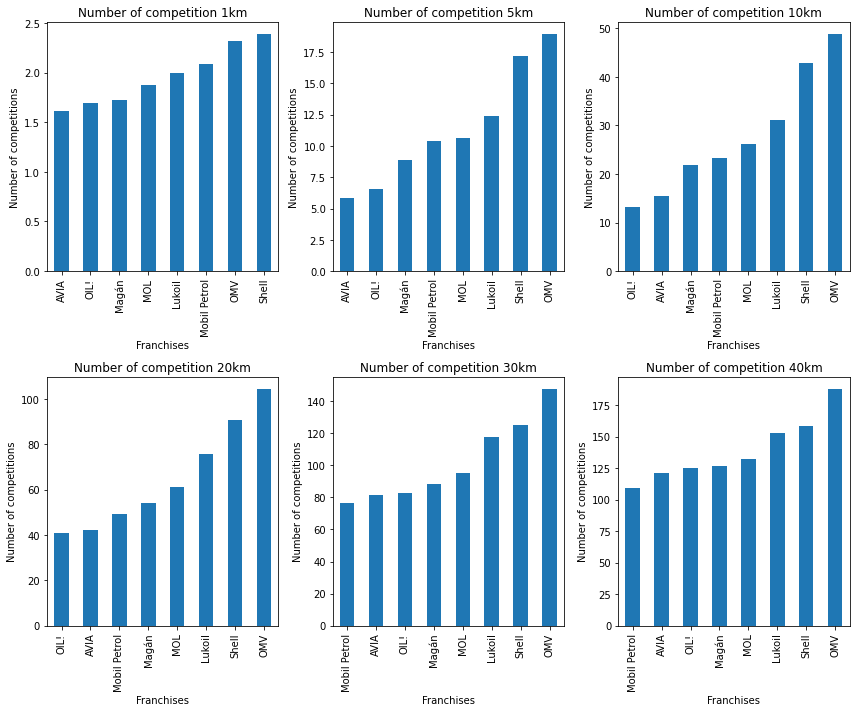

In [13]:
radius = ['Number of competition 1km','Number of competition 5km','Number of competition 10km','Number of competition 20km', 'Number of competition 30km', 'Number of competition 40km']
mean_competitions = gas_stations.groupby('Franchise (or private)')[radius].mean()

# create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10))

# flatten the axes array for easier iteration
axes = axes.flatten()

# iterate over the columns and plot each one
for i, col in enumerate(mean_competitions.columns):
    ax = axes[i]
    mean_competitions[col].sort_values().plot(kind='bar', ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Franchises')
    ax.set_ylabel('Number of competitions')
    
    
# adjust the layout and show the plot
plt.tight_layout()
plt.show()

## Highway Column

In [14]:
gas_stations.groupby('Highway')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő']].mean()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-1 Elektromos Töltő,Type-2 Elektromos Töltő,Chademo Elektromos Töltő,Ccs - Elektromos Töltő
Highway,,,,,,,,,,,,
0,608.859327,589.317973,353.362698,653.915826,644.336442,639.190189,633.276,510.946341,89.0,94.0,89.0,NaN
1,632.010000,609.762963,383.638462,674.364557,664.022500,664.025000,NaN,599.500000,NaN,119.0,119.0,119.0


This clearly shows that the prices are higher next to Highways, also there is significant difference in standard deviations.

In [15]:
gas_stations.groupby('Highway')[['95-ös Benzin E10', 'Gázolaj', 'Lpg',
       '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10',
       '98-As Benzin E5', 'Adblue', 'Type-1 Elektromos Töltő',
       'Type-2 Elektromos Töltő', 'Chademo Elektromos Töltő',
       'Ccs - Elektromos Töltő']].std()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-1 Elektromos Töltő,Type-2 Elektromos Töltő,Chademo Elektromos Töltő,Ccs - Elektromos Töltő
Highway,,,,,,,,,,,,
0,5.656581,6.974885,18.601804,16.535949,10.434635,4.065829,20.98641,120.921580,NaN,21.213203,NaN,NaN
1,10.399131,8.659005,25.304780,20.231646,13.733623,9.251852,NaN,1.732051,NaN,NaN,NaN,NaN


## 'Correlation' between the categorical variables:

Cramer's V is a measure of association between two categorical variables and ranges from 0 to 1, where 0 indicates no association and 1 indicates a strong association.

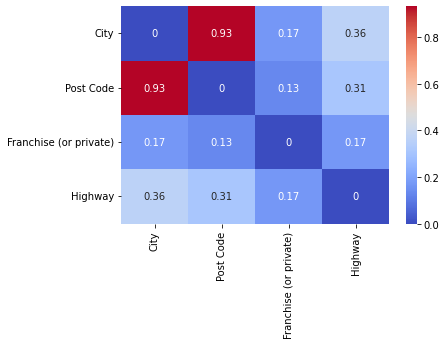

In [16]:
cat_val = gas_stations[['City', 'Post Code', 'Franchise (or private)', 'Highway']]

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corrected = r - ((r-1)**2)/(n-1)
    k_corrected = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corrected/min((k_corrected-1),(r_corrected-1)))

# create an empty correlation matrix
corr_matrix = pd.DataFrame(np.zeros((len(cat_val.columns), len(cat_val.columns))), columns=cat_val.columns, index=cat_val.columns)

# compute Cramer's V for each pair of columns
for i in range(len(cat_val.columns)):
    for j in range(i+1, len(cat_val.columns)):
        v = cramers_v(cat_val.iloc[:, i], cat_val.iloc[:, j])
        corr_matrix.iloc[i, j] = v
        corr_matrix.iloc[j, i] = v

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

## Correlation on Numerical Variables:

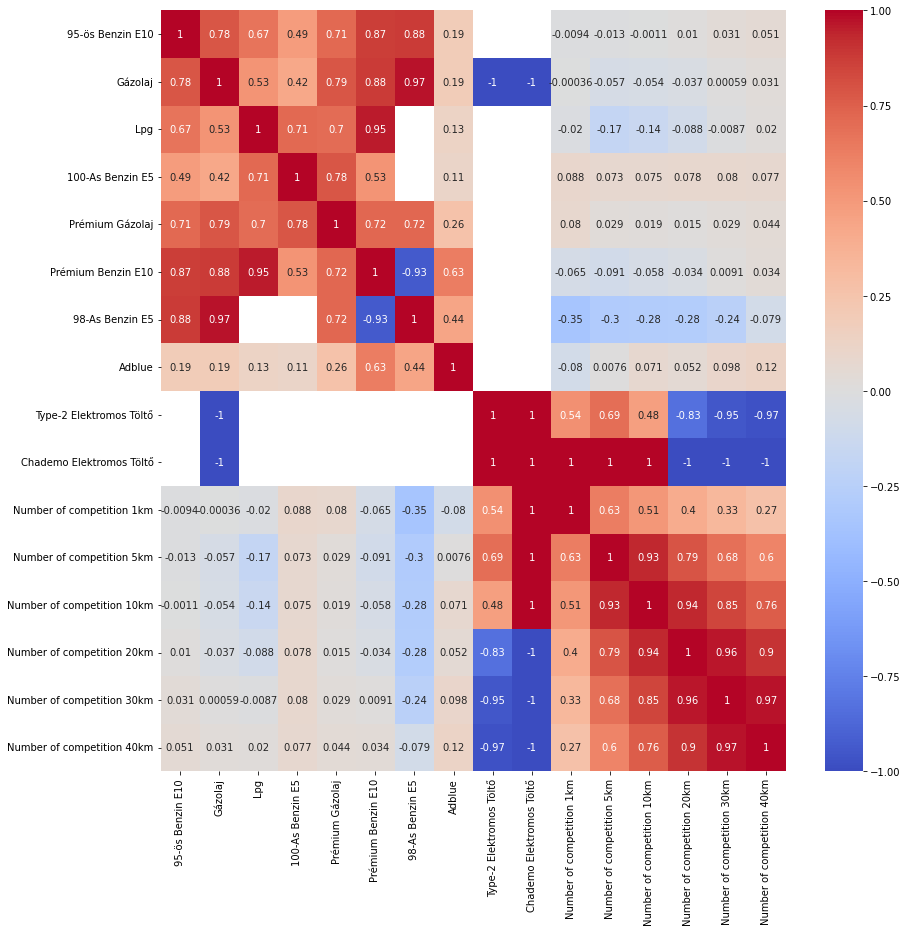

In [17]:
numerical = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5',
       'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue',
        'Type-2 Elektromos Töltő',
       'Chademo Elektromos Töltő',
       'Number of competition 1km', 'Number of competition 5km',
       'Number of competition 10km', 'Number of competition 20km',
       'Number of competition 30km', 'Number of competition 40km']

float_val = gas_stations[numerical]
corr = float_val.corr()
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Show the plot
plt.show()


## Price Attributes:

In [18]:
prices = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5',
       'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue',
        'Type-2 Elektromos Töltő',
       'Chademo Elektromos Töltő']

gas_stations[prices].describe()

,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue,Type-2 Elektromos Töltő,Chademo Elektromos Töltő
count,1120.000000,1127.000000,291.000000,932.000000,895.000000,297.000000,25.00000,94.000000,3.000000,2.000000
mean,610.512946,590.787400,357.420275,655.649142,646.096089,641.865993,633.27600,522.251064,102.333333,104.000000
std,8.539542,8.853498,22.139267,17.804572,12.140215,9.121505,20.98641,116.697634,20.816660,21.213203
min,580.000000,563.000000,320.000000,613.900000,589.000000,606.900000,620.00000,310.000000,79.000000,89.000000
25%,609.900000,589.900000,353.000000,647.000000,644.900000,638.900000,627.00000,439.925000,94.000000,96.500000
50%,610.000000,590.900000,353.000000,647.000000,646.000000,640.900000,627.00000,559.000000,109.000000,104.000000
75%,610.000000,591.000000,353.000000,659.925000,646.000000,640.900000,627.00000,599.000000,114.000000,111.500000
max,651.000000,680.000000,490.000000,728.000000,688.900000,668.900000,727.00000,860.000000,119.000000,119.000000


As we can see we have fresh data, since there are no 480 priced minimum.

## Number of competitions in radius:

Here we will check basic statistics about these attributes.

In [19]:
comp = ['Number of competition 1km', 'Number of competition 5km',
       'Number of competition 10km', 'Number of competition 20km',
       'Number of competition 30km', 'Number of competition 40km']
gas_stations[comp].describe()

,Number of competition 1km,Number of competition 5km,Number of competition 10km,Number of competition 20km,Number of competition 30km,Number of competition 40km
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,1.984968,12.238924,30.348892,69.357595,105.350475,142.650316
std,1.234473,16.334679,44.859534,90.238131,112.456335,123.643344
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,5.000000,16.000000,35.000000,57.000000
50%,2.000000,5.000000,11.000000,27.000000,47.000000,77.000000
75%,3.000000,15.250000,24.000000,41.250000,151.250000,305.000000
max,6.000000,72.000000,167.000000,273.000000,321.000000,379.000000


## Number of competitions and Gas Prices plots:

### 1 km radius competition price change:

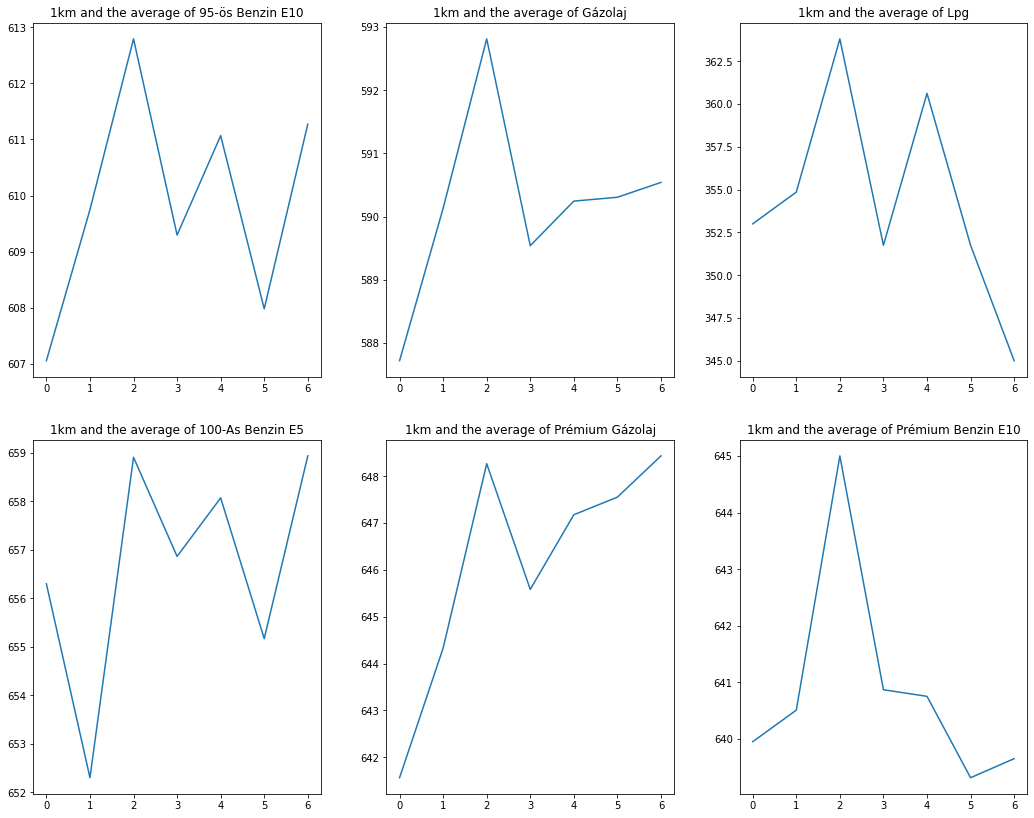

In [20]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']

fuel_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue']

fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[0]].sort_values().unique()
y1 = gas_stations.groupby(comp[0])[fuel_types[0]].mean()
y2 = gas_stations.groupby(comp[0])[fuel_types[1]].mean()
y3 = gas_stations.groupby(comp[0])[fuel_types[2]].mean()
y4 = gas_stations.groupby(comp[0])[fuel_types[3]].mean()
y5 = gas_stations.groupby(comp[0])[fuel_types[4]].mean()
y6 = gas_stations.groupby(comp[0])[fuel_types[5]].mean()

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[0][-3:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[0][-3:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[0][-3:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[0][-3:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[0][-3:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[0][-3:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 5 km radius competition price change:

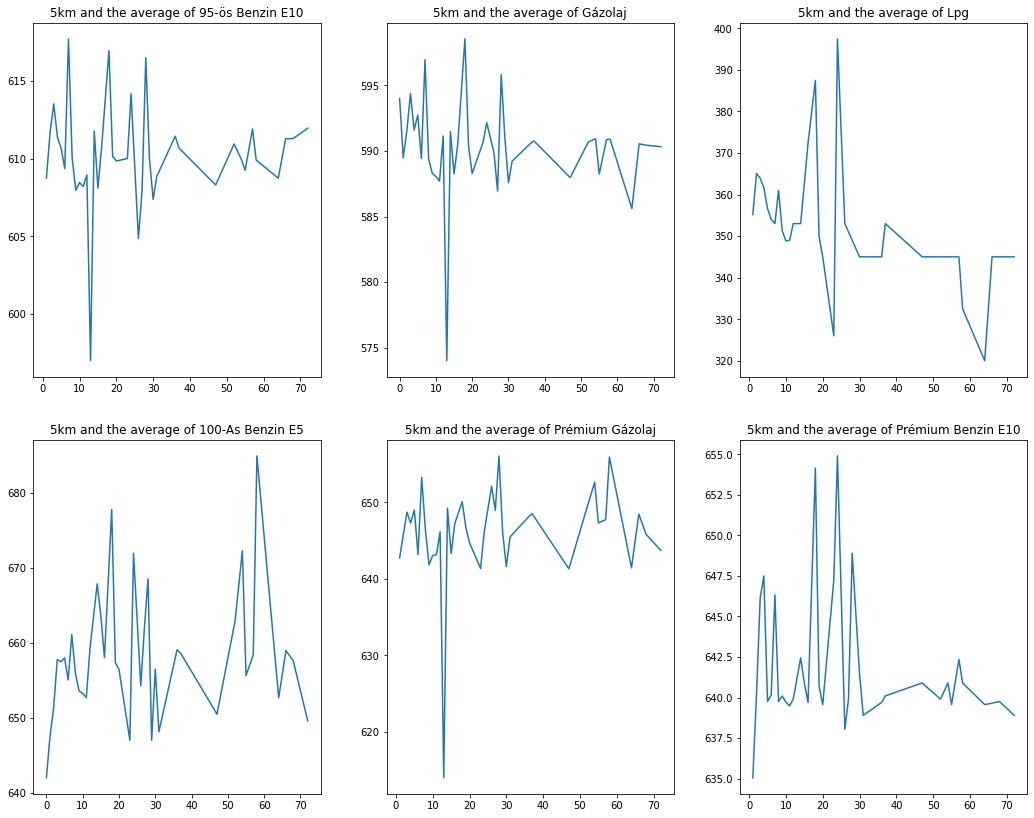

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[1]].sort_values().unique()
y1 = gas_stations.groupby(comp[1])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[1])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[1])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[1])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[1])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[1])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[1][-3:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[1][-3:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[1][-3:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[1][-3:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[1][-3:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[1][-3:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 10 km radius competition price change:

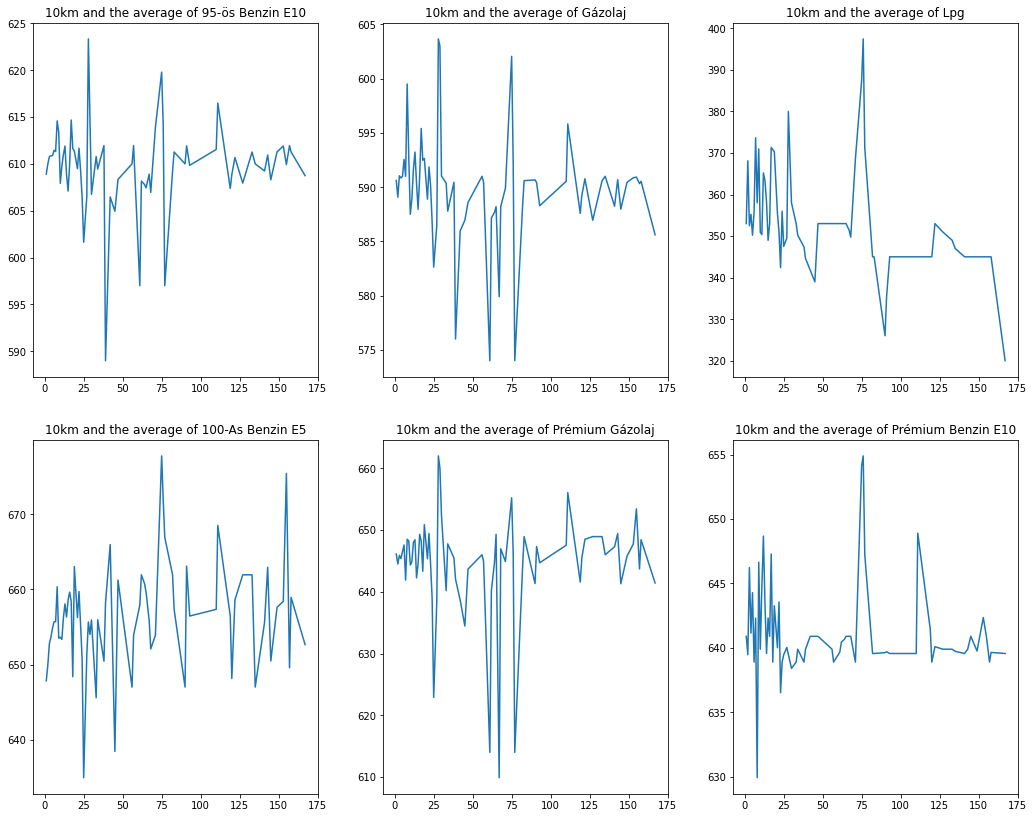

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[2]].sort_values().unique()
y1 = gas_stations.groupby(comp[2])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[2])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[2])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[2])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[2])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[2])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[2][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[2][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[2][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[2][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[2][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[2][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 20 km radius competition price change:

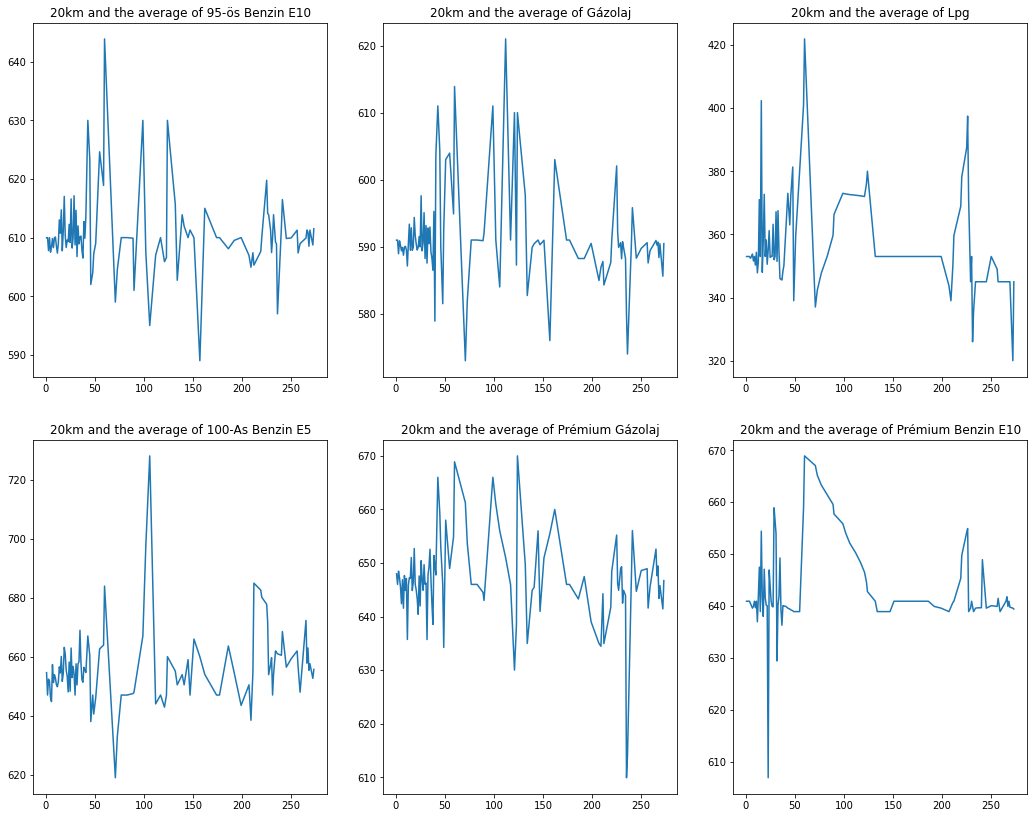

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[3]].sort_values().unique()
y1 = gas_stations.groupby(comp[3])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[3])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[3])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[3])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[3])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[3])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[3][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[3][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[3][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[3][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[3][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[3][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 30 km radius competition price change:

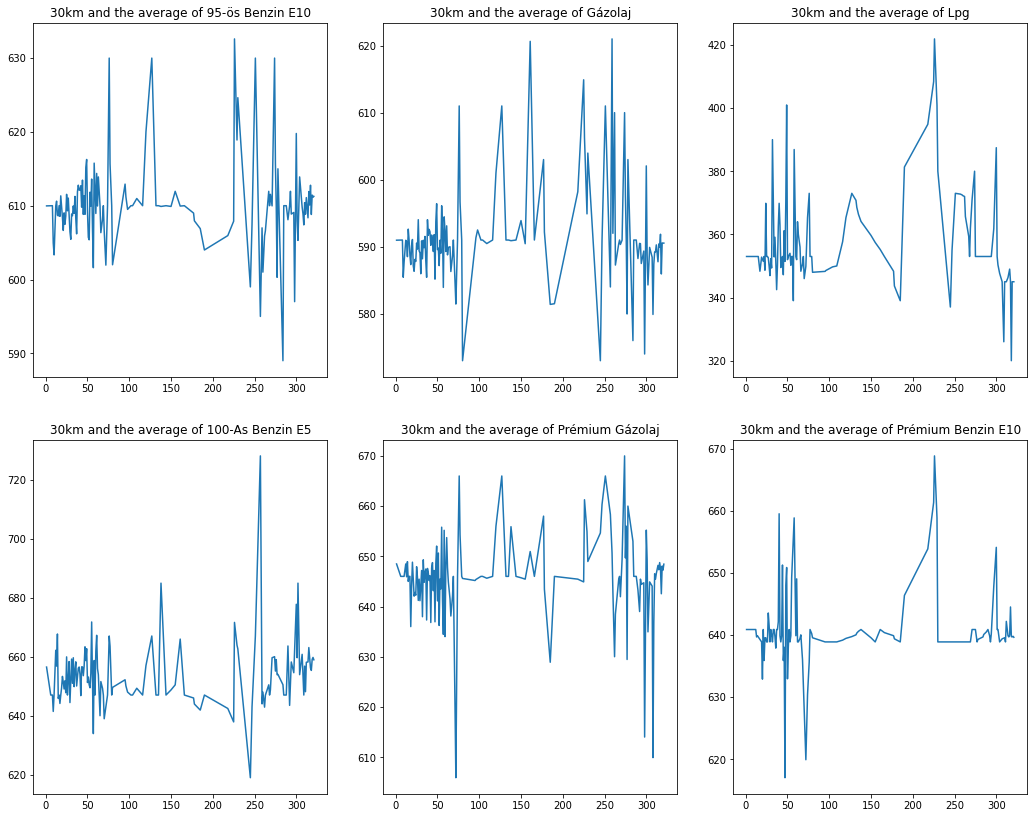

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[4]].sort_values().unique()
y1 = gas_stations.groupby(comp[4])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[4])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[4])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[4])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[4])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[4])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[4][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[4][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[4][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[4][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[4][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[4][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

### 40 km radius competition price change:

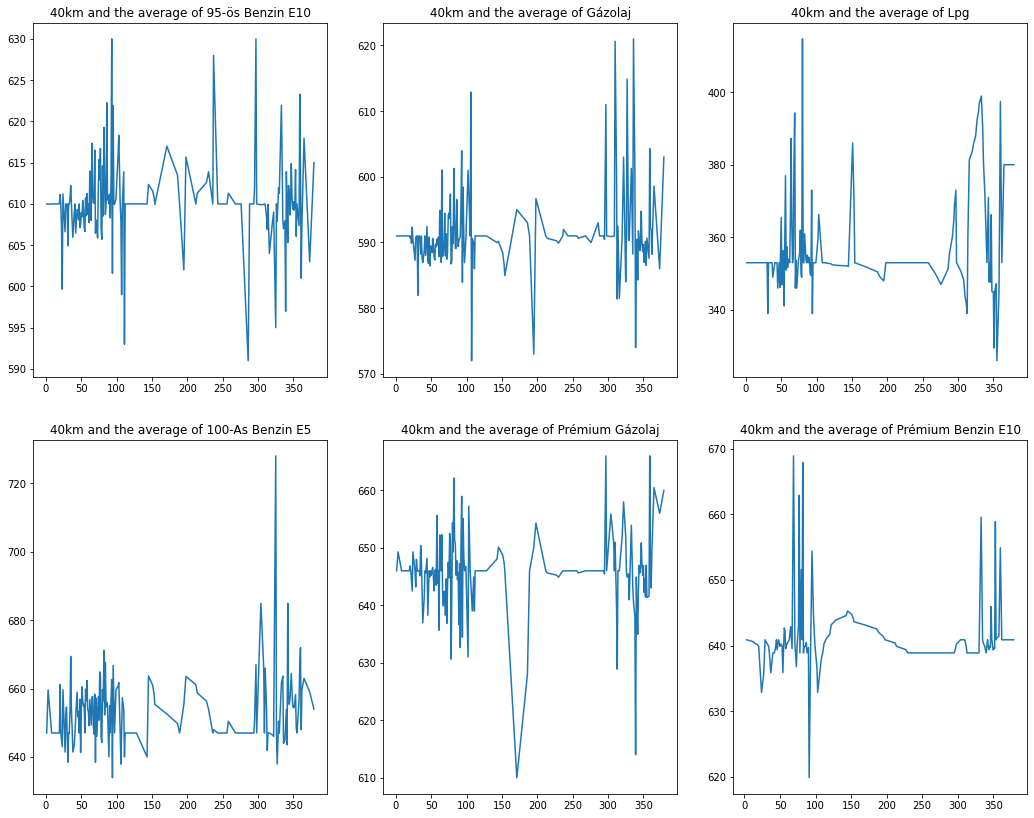

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

x = gas_stations[comp[5]].sort_values().unique()
y1 = gas_stations.groupby(comp[5])[fuel_types[0]].mean().interpolate(method='linear')
y2 = gas_stations.groupby(comp[5])[fuel_types[1]].mean().interpolate(method='linear')
y3 = gas_stations.groupby(comp[5])[fuel_types[2]].mean().interpolate(method='linear')
y4 = gas_stations.groupby(comp[5])[fuel_types[3]].mean().interpolate(method='linear')
y5 = gas_stations.groupby(comp[5])[fuel_types[4]].mean().interpolate(method='linear')
y6 = gas_stations.groupby(comp[5])[fuel_types[5]].mean().interpolate(method='linear')

axs[0, 0].plot(x, y1)
axs[0, 0].set_title(f'{comp[5][-4:]} and the average of {fuel_types[0]}')
axs[0, 1].plot(x, y2)
axs[0, 1].set_title(f'{comp[5][-4:]} and the average of {fuel_types[1]}')
axs[0, 2].plot(x, y3)
axs[0, 2].set_title(f'{comp[5][-4:]} and the average of {fuel_types[2]}')
axs[1, 0].plot(x, y4)
axs[1, 0].set_title(f'{comp[5][-4:]} and the average of {fuel_types[3]}')
axs[1, 1].plot(x, y5)
axs[1, 1].set_title(f'{comp[5][-4:]} and the average of {fuel_types[4]}')
axs[1, 2].plot(x, y6)
axs[1, 2].set_title(f'{comp[5][-4:]} and the average of {fuel_types[5]}')
plt.tight_layout(pad=3.0)
plt.show()

## Analyzing County (megye in hungarian) Prices:

Check out the following link: https://irányítószámok.cybo.com/magyarorsz%C3%A1g/

In [26]:
def get_region(zip_code):
    if 1011 <= zip_code <= 1806:
        return 'Budapest'
    elif 2000 <= zip_code <= 2769:
        return 'Pest megye'
    elif (2400 <= zip_code <= 2490) or (8000 <= zip_code <= 8157):
        return 'Fejér megye'
    elif (2500 <= zip_code <= 2545) or (2800 <= zip_code <= 2949):
        return 'Komárom-Esztergom megye'
    elif (2640 <= zip_code <= 2699) or (3041 <= zip_code <= 3253):
        return 'Nógrád megye'
    elif (3000 <= zip_code <= 3036) or (3200 <= zip_code <= 3399):
        return 'Heves megye'
    elif 3400 <= zip_code <= 3999:
        return 'Borsod-Abaúj-Zemplén megye'
    elif 4000 <= zip_code <= 4288:
        return 'Hajdú-Bihar megye'
    elif (4300 <= zip_code <= 4977):
        return 'Szabolcs-Szatmár-Bereg megye'
    elif (5000 <= zip_code <= 5476):
        return 'Jász-Nagykun-Szolnok megye'
    elif (5500 <= zip_code <= 5948):
        return 'Békés megye'
    elif (6000 <= zip_code <= 6528):
        return 'Bács-Kiskun megye'
    elif (6600 <= zip_code <= 6932):
        return 'Csongrád vármegye'
    elif (7020 <= zip_code <= 7228):
        return 'Tolna megye'
    elif (7300 <= zip_code <= 7396) or (7600 <= zip_code <= 7985):
        return 'Baranya megye'
    elif (7400 <= zip_code <= 7589) or (8600 <= zip_code <= 8739):
        return 'Somogy vármegye'
    elif 8161 <= zip_code <= 8598:
        return 'Veszprém megye'
    elif (8353 <= zip_code <= 8395) or (8741 <= zip_code <= 8999):
        return 'Zala megye'
    elif 9001 <= zip_code <= 9495:
        return 'Győr-Moson-Sopron megye'
    elif 9500 <= zip_code <= 9985:
        return 'Vas megye'
    else:
        return 'NONE'
    
gas_stations['County'] = gas_stations['Post Code'].apply(get_region)

In [27]:
gas_stations.groupby('County')['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()

/tmp/ipykernel_139451/2733603437.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gas_stations.groupby('County')['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()


,95-ös Benzin E10,Gázolaj,Lpg,100-As Benzin E5,Prémium Gázolaj,Prémium Benzin E10,98-As Benzin E5,Adblue
County,,,,,,,,
Baranya megye,609.347619,589.847619,351.658333,654.158333,644.382353,640.200000,NaN,599.000000
Borsod-Abaúj-Zemplén megye,607.970312,589.329687,352.333333,653.800000,644.535556,644.215385,625.000000,572.966667
Budapest,610.831737,589.885629,344.550000,658.066667,647.065359,640.750000,627.000000,589.500000
Bács-Kiskun megye,611.032877,591.005405,350.234483,655.108333,643.292727,639.446667,627.000000,528.460000
Békés megye,609.505714,589.044444,351.988889,653.478788,644.793103,635.900000,NaN,329.900000
Csongrád vármegye,608.862000,588.062000,352.037500,654.087805,641.409302,639.685714,627.000000,359.683333
Fejér megye,612.357576,591.056250,354.846154,658.860000,650.033333,645.300000,627.000000,527.000000
Győr-Moson-Sopron megye,609.141935,590.998438,363.926667,653.258140,648.237500,638.369231,650.000000,501.825000
Hajdú-Bihar megye,610.627660,590.244681,359.000000,652.241860,645.553659,639.788889,627.000000,574.250000


In [28]:
gas_stations.groupby(['County', 'Highway'])['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()

/tmp/ipykernel_139451/810543516.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  gas_stations.groupby(['County', 'Highway'])['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue'].mean()


95-ös Benzin E10     Gázolaj  \
County                       Highway                                 
Baranya megye                0              609.347619  589.847619   
                             1                     NaN         NaN   
Borsod-Abaúj-Zemplén megye   0              606.908065  588.408065   
                             1              640.900000  617.900000   
Budapest                     0              610.263415  589.397561   
                             1              641.900000  616.566667   
Bács-Kiskun megye            0              609.011940  589.070588   
                             1              633.600000  612.933333   
Békés megye                  0              609.505714  589.044444   
                             1                     NaN         NaN   
Csongrád vármegye            0              606.419565  585.941304   
                             1              636.950000  612.450000   
Fejér megye                  0              609.172414  587.714286   
                             1              635.450000  614.450000   
Győr-Moson-Sopron megye      0              608.081356  589.881667   
                             1              630.000000  607.750000   
Hajdú-Bihar megye            0              609.042857  588.495238   
                             1              623.940000  604.940000   
Heves megye                  0              609.595238  589.738095   
                             1              634.633333  611.966667   
Jász-Nagykun-Szolnok megye   0              609.485366  589.778049   
                             1                     NaN         NaN   
Komárom-Esztergom megye      0              608.396667  588.496667   
                             1              642.400000  615.900000   
NONE                         0              609.740000  588.581818   
                             1                     NaN         NaN   
Nógrád megye                 0              609.828571  591.638095   
                             1                     NaN         NaN   
Pest megye                   0              608.454422  590.235135   
                             1              627.622222  605.103704   
Somogy vármegye              0              609.051429  589.480000   
                             1              633.633333  613.300000   
Szabolcs-Szatmár-Bereg megye 0              610.043902  589.775610   
                             1              629.900000  609.900000   
Tolna megye                  0              608.560000  590.961290   
                             1              634.600000  611.600000   
Vas megye                    0              607.874286  591.217143   
                             1                     NaN         NaN   
Veszprém megye               0              608.767925  589.251852   
                             1                     NaN         NaN   
Zala megye                   0              608.020000  587.020000   
                             1              630.000000  611.000000   

                                             Lpg  100-As Benzin E5  \
County                       Highway                                 
Baranya megye                0        351.658333        654.158333   
                             1               NaN               NaN   
Borsod-Abaúj-Zemplén megye   0        352.333333        651.521569   
                             1               NaN        711.900000   
Budapest                     0        344.550000        657.176667   
                             1               NaN        702.566667   
Bács-Kiskun megye            0        349.585185        652.387037   
                             1        359.000000        679.600000   
Békés megye                  0        351.988889        653.478788   
                             1               NaN               NaN   
Csongrád vármegye            0        342.955000        651.778378   
                             1        397.45000

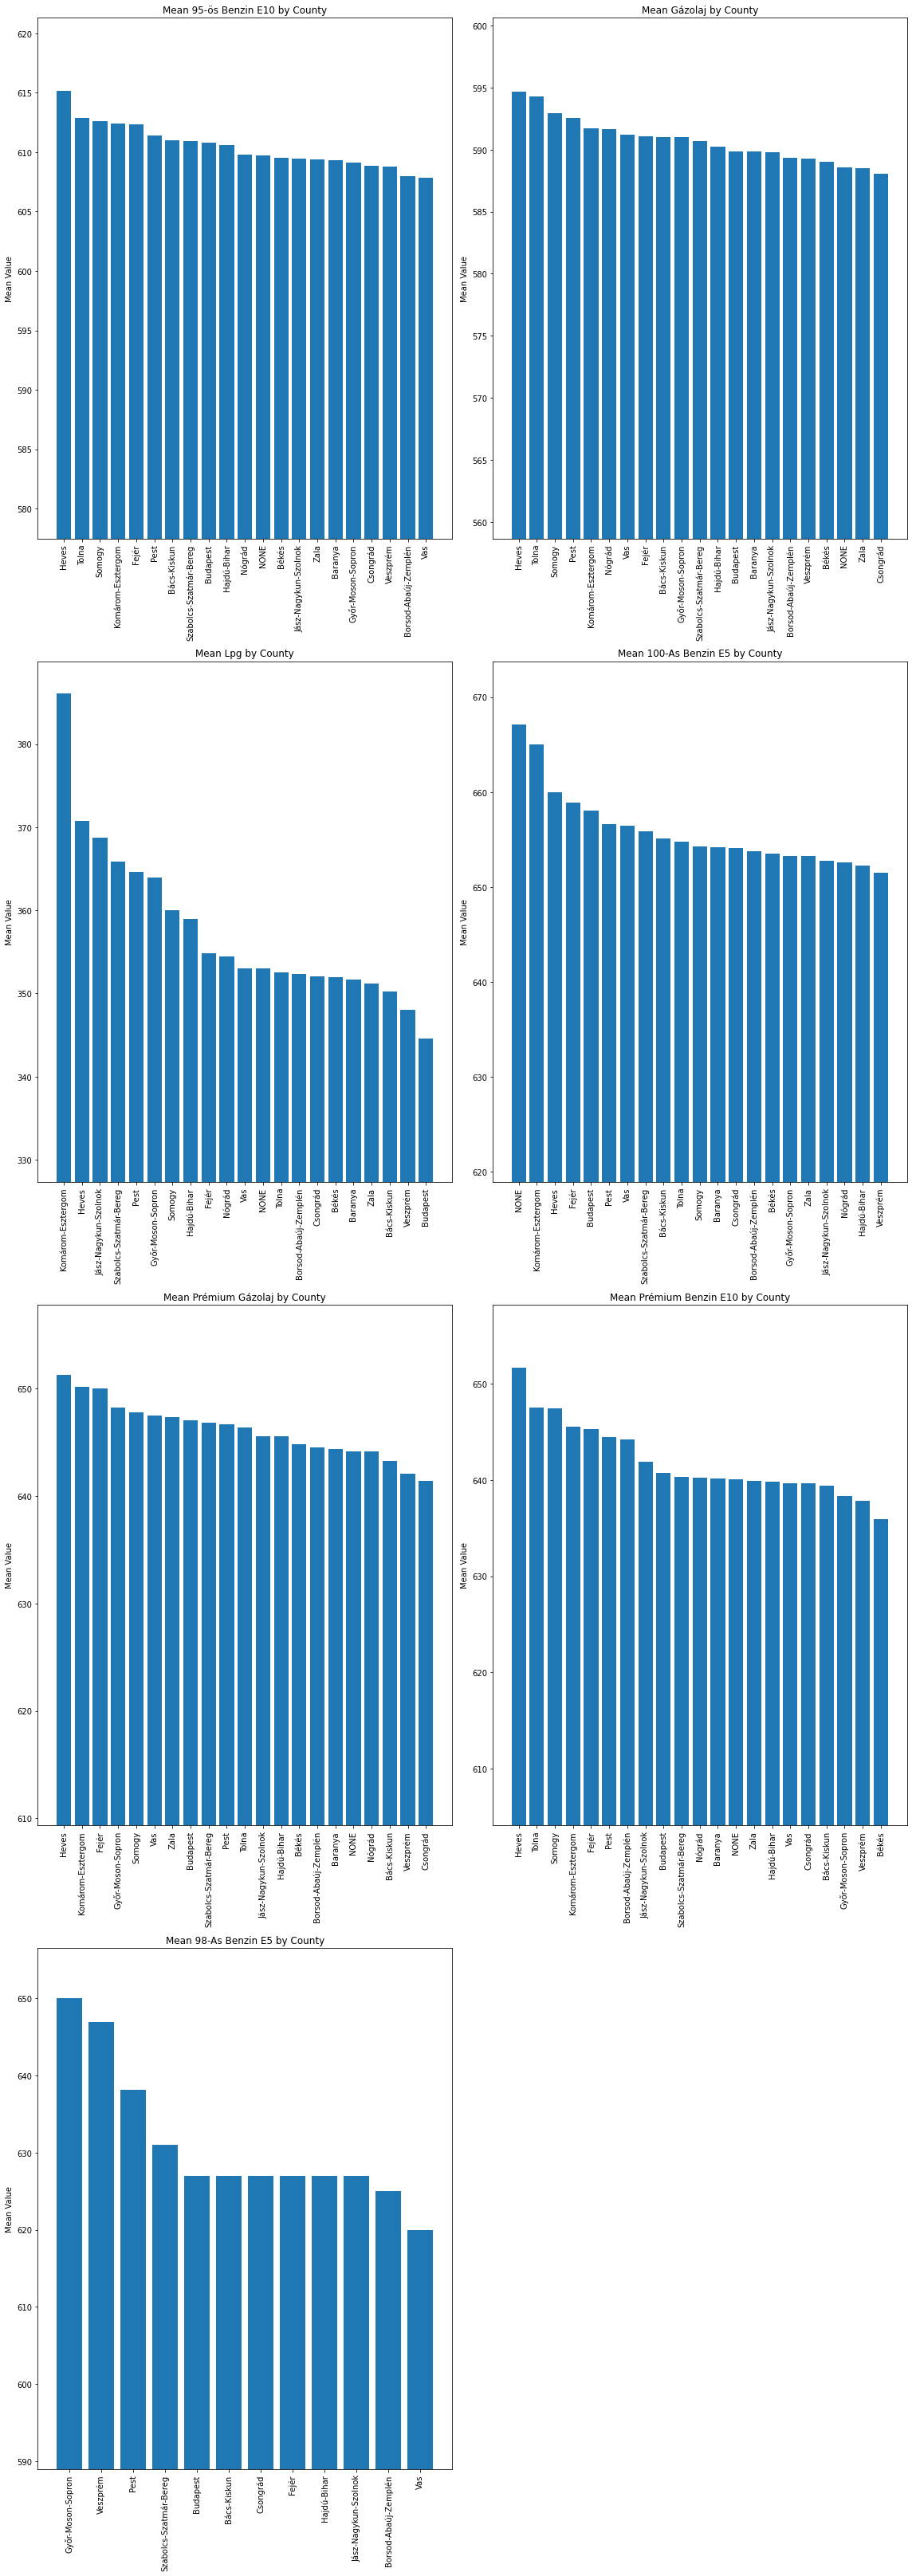

In [29]:
# Group the data by county and calculate the mean of fuel types
fuel_types = ['95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue']
grouped_data = gas_stations.groupby('County')[fuel_types].mean()

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(16, 45))

# Loop through the fuel types and create a subplot for each
for i, fuel in enumerate(fuel_types):
    # Sort the data in descending order based on the mean of the current fuel type
    sorted_data = grouped_data.sort_values(by=fuel, ascending=False)
    # Calculate the row and column indices of the subplot
    row = i // 2
    col = i % 2
    # Create a bar plot in the current subplot
    x_values = [county.split(' ')[0] for county in sorted_data.index]
    axs[row, col].bar(x_values, sorted_data[fuel])
    # Set the title and y-axis label
    axs[row, col].set_title(f'Mean {fuel} by County')
    axs[row, col].set_ylabel('Mean Value')
    # Rotate the x-axis labels for better readability
    axs[row, col].tick_params(axis='x', rotation=90)
    # Adjust the y-axis limits to remove extra whitespace
    #ymin, ymax = axs[row, col].get_ylim()
    #axs[row, col].set_ylim(ymin*0.95, ymax*1.2)
    
    # Set the y-axis limits
    axs[row, col].set_ylim(sorted_data[fuel].min() * 0.95, sorted_data[fuel].max()*1.01)

# Remove the extra subplot
fig.delaxes(axs[3, 1])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

In [30]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']
print('Average number of competitions based on county:')
gas_stations.groupby('County')[comp].mean()

Average number of competitions based on county:


,Number of competition 1km,Number of competition 5km,Number of competition 10km,Number of competition 20km,Number of competition 30km,Number of competition 40km
County,,,,,,
Baranya megye,1.159091,3.545455,8.840909,17.613636,36.386364,60.227273
Borsod-Abaúj-Zemplén megye,2.157143,5.271429,13.257143,25.771429,49.371429,72.442857
Budapest,3.286550,46.269006,134.017544,258.935673,315.578947,348.456140
Bács-Kiskun megye,1.645161,6.956989,9.505376,20.602151,38.075269,70.623656
Békés megye,1.972222,5.250000,7.083333,12.944444,21.444444,40.527778
Csongrád vármegye,2.148148,9.259259,13.425926,26.851852,41.518519,56.629630
Fejér megye,1.076923,10.512821,14.769231,32.410256,64.923077,136.307692
Győr-Moson-Sopron megye,2.200000,10.414286,15.700000,22.471429,38.914286,59.171429
Hajdú-Bihar megye,1.509434,8.188679,9.924528,20.622642,35.886792,60.452830


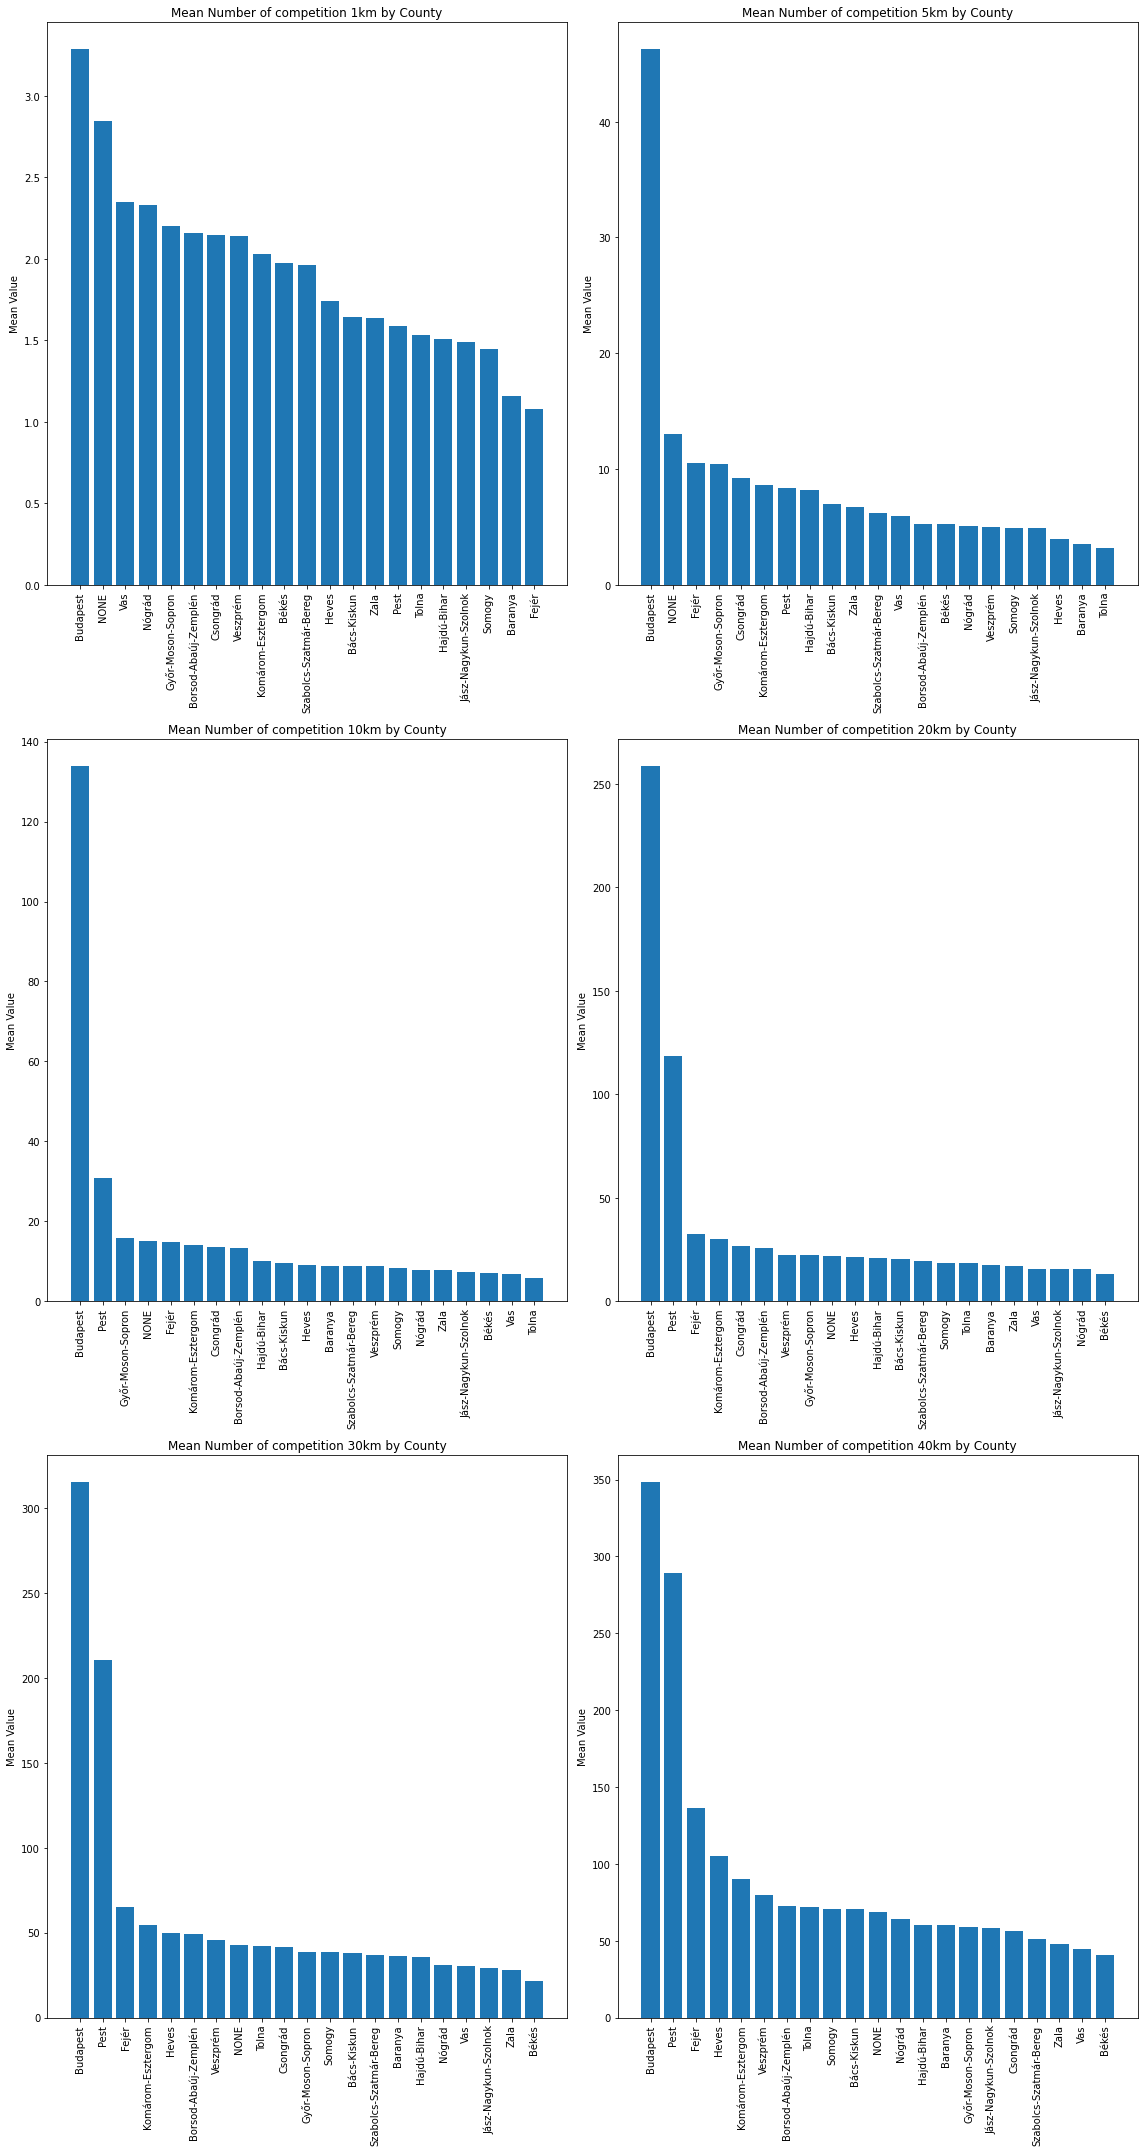

In [31]:
comp = ['Number of competition 1km', 'Number of competition 5km', 'Number of competition 10km', 'Number of competition 20km','Number of competition 30km', 'Number of competition 40km']
grouped_data = gas_stations.groupby('County')[comp].mean()

# Create a figure with 4 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(16, 30))

# Loop through the fuel types and create a subplot for each
for i, fuel in enumerate(comp):
    # Sort the data in descending order based on the mean of the current fuel type
    sorted_data = grouped_data.sort_values(by=fuel, ascending=False)
    # Calculate the row and column indices of the subplot
    row = i // 2
    col = i % 2
    # Create a bar plot in the current subplot
    x_values = [county.split(' ')[0] for county in sorted_data.index]
    axs[row, col].bar(x_values, sorted_data[fuel])
    # Set the title and y-axis label
    axs[row, col].set_title(f'Mean {fuel} by County')
    axs[row, col].set_ylabel('Mean Value')
    # Rotate the x-axis labels for better readability
    axs[row, col].tick_params(axis='x', rotation=90)

# Remove the extra subplot
#fig.delaxes(axs[3, 1])

# Adjust the spacing between the subplots
fig.tight_layout()

# Show the plot
plt.show()

Let's check out that are the categorical values independent from the newly created County variable.

In [32]:
cont_table = pd.crosstab(gas_stations['Franchise (or private)'], gas_stations['County'])

# Perform chi-squared test
chi2, p_value, dof, expected = chi2_contingency(cont_table)

print(f"Chi-square statistic for Franchise and County: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic for Franchise and County: 245.80714633778535
P-value: 8.294457196752023e-08


The Chi-square statistic of 245.81 is relatively large, and the very small p-value of 8.29e-08 indicates strong evidence against the null hypothesis. Therefore, we can conclude that there is a significant association between Franchise and County.

In [33]:
gas_stations.columns

Index(['City', 'Post Code', 'Franchise (or private)', 'Highway',
       '95-ös Benzin E10', 'Gázolaj', 'Lpg', '100-As Benzin E5', 'Cng',
       'Prémium Gázolaj', 'Prémium Benzin E10', '98-As Benzin E5', 'Adblue',
       'Type-1 Elektromos Töltő', 'Type-2 Elektromos Töltő',
       'Chademo Elektromos Töltő', 'Ccs - Elektromos Töltő',
       'Number of competition 1km', 'Number of competition 5km',
       'Number of competition 10km', 'Number of competition 20km',
       'Number of competition 30km', 'Number of competition 40km', 'County'],
      dtype='object')